In [1]:
from tkinter import *
import random
import time
import enum
import numpy as np
import random
from PIL import ImageTk,Image
import matplotlib.pyplot as plt
### CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

import seaborn as sns
sns.set_theme(style="darkgrid")

# Define useful parameters
size_of_board = 600
rows = 10
cols = 10
DELAY = 100
snake_initial_length = 5
symbol_size = (size_of_board / 3 - size_of_board / 8) / 2
symbol_thickness = 2
RED_COLOR = "#EE4035"
BLUE_COLOR = "#0492CF"
GREEN_COLOR = "#7BC043"

BLUE_COLOR_LIGHT = '#67B0CF'
RED_COLOR_LIGHT = '#EE7E77'

class StrEnum(str, enum.Enum):
    pass

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
class SnakeAndApple:
    
    class Directions(StrEnum):
        UP = "Up"
        DOWN = "Down"
        LEFT = "Left"
        RIGHT = "Right"

    def __init__(self):
        self.set_window()
        self.plot = True
        self.state_space = 12
        self.snake_heading = self.Directions.RIGHT

    def set_window(self):
        self.window = Tk()
        self.window.title("Snake-and-Apple")
        self.canvas = Canvas(self.window, width=size_of_board, height=size_of_board)
        self.canvas.pack()

    def initialize_board(self):
        self.board = []
        self.apple_obj = []
        self.old_apple_cell = []

        for i in range(rows):
            for j in range(cols):
                self.board.append((i, j))

        if self.plot:
            for i in range(rows):
                self.canvas.create_line(
                    i * size_of_board / rows, 0, i * size_of_board / rows, size_of_board,
                )

            for i in range(cols):
                self.canvas.create_line(
                    0, i * size_of_board / cols, size_of_board, i * size_of_board / cols,
                )

    def initialize_snake(self):
        self.snake = []
        self.crashed = False
        self.got_apple = False
        self.snake_heading = self.Directions.RIGHT
        self.snake_objects = []
        for i in range(snake_initial_length):
            self.snake.append((i, 0))

    def random_apple_spot(self):
        # Place apple randomly anywhere except at the cells occupied by snake
        unoccupied_cels = set(self.board) - set(self.snake)
        self.apple_cell = random.choice(list(unoccupied_cels))

    def place_apple(self):
        row_h = int(size_of_board / rows)
        col_w = int(size_of_board / cols)
        x1 = self.apple_cell[0] * row_h
        y1 = self.apple_cell[1] * col_w
        x2 = x1 + row_h
        y2 = y1 + col_w
        if self.plot:
            self.apple_obj = self.canvas.create_rectangle(
                x1, y1, x2, y2, fill=RED_COLOR_LIGHT, outline=BLUE_COLOR,
            )

    def display_snake(self, mode=""):
        # Remove tail from display if it exists
        if self.snake_objects != []:
            self.canvas.delete(self.snake_objects.pop(0))
        if mode == "complete":
            for i, cell in enumerate(self.snake):
                # print(cell)
                row_h = int(size_of_board / rows)
                col_w = int(size_of_board / cols)
                x1 = cell[0] * row_h
                y1 = cell[1] * col_w
                x2 = x1 + row_h
                y2 = y1 + col_w
                self.snake_objects.append(
                    self.canvas.create_rectangle(
                        x1, y1, x2, y2, fill=BLUE_COLOR, outline=BLUE_COLOR,
                    )
                )
            self.window.update()
        else:
            # only update head
            cell = self.snake[-1]
            row_h = int(size_of_board / rows)
            col_w = int(size_of_board / cols)
            x1 = cell[0] * row_h
            y1 = cell[1] * col_w
            x2 = x1 + row_h
            y2 = y1 + col_w
            self.snake_objects.append(
                self.canvas.create_rectangle(
                    x1, y1, x2, y2, fill=BLUE_COLOR, outline=RED_COLOR,
                )
            )
            if self.snake[0] == self.old_apple_cell:
                self.snake.insert(0, self.old_apple_cell)
                self.old_apple_cell = []
                tail = self.snake[0]
                row_h = int(size_of_board / rows)
                col_w = int(size_of_board / cols)
                x1 = tail[0] * row_h
                y1 = tail[1] * col_w
                x2 = x1 + row_h
                y2 = y1 + col_w
                self.snake_objects.insert(
                    0,
                    self.canvas.create_rectangle(
                        x1, y1, x2, y2, fill=BLUE_COLOR, outline=RED_COLOR
                    ),
                )
            self.window.update()

    def start(self):
        try:
            self.canvas.delete("all")
        except:
            self.set_window()
        self.initialize_board()
        self.initialize_snake()
        self.random_apple_spot()
        self.place_apple()
        self.dist = self.distance(self.snake[-1], self.apple_cell)
        if self.plot:
            self.display_snake(mode="complete")

    def reset(self):
        try:
            self.canvas.delete("all")
        except:
            self.set_window()
        self.initialize_board()
        self.initialize_snake()
        self.place_apple()
        self.dist = self.distance(self.snake[-1], self.apple_cell)
        if self.plot:
            self.display_snake(mode="complete")

    def step(self, key):
        # Check if it hit the wall or its own body
        tail = self.snake[0]
        head = self.snake[-1]
        if tail != self.old_apple_cell:
            self.snake.pop(0)
        if key == self.Directions.LEFT:
            self.snake.append((head[0] - 1, head[1]))
        elif key == self.Directions.RIGHT:
            self.snake.append((head[0] + 1, head[1]))
        elif key == self.Directions.UP:
            self.snake.append((head[0], head[1] - 1))
        elif key == self.Directions.DOWN:
            self.snake.append((head[0], head[1] + 1))

        head = self.snake[-1]
        if (
                head[0] > cols - 1
                or head[0] < 0
                or head[1] > rows - 1
                or head[1] < 0
                or len(set(self.snake)) != len(self.snake)
        ):
            # Hit the wall / Hit on body
            self.crashed = True
            reward = -100
        elif self.apple_cell == head:
            # Got the apple
            self.got_apple = True
            if self.plot:
                self.old_apple_cell = self.apple_cell
                self.canvas.delete(self.apple_obj)
                self.place_apple()
                self.display_snake()
                self.window.after(DELAY)
            reward = 10
        else:
            self.snake_heading = key
            if self.plot:
                self.display_snake()
                self.window.after(DELAY)
            reward = -1
        return reward

    def step2(self, key):
        # Check if it hit the wall or its own body
        tail = self.snake[0]
        head = self.snake[-1]
        if tail != self.old_apple_cell:
            self.snake.pop(0)
        if key == self.Directions.LEFT:
            self.snake.append((head[0] - 1, head[1]))
        elif key == self.Directions.RIGHT:
            self.snake.append((head[0] + 1, head[1]))
        elif key == self.Directions.UP:
            self.snake.append((head[0], head[1] - 1))
        elif key == self.Directions.DOWN:
            self.snake.append((head[0], head[1] + 1))

        head = self.snake[-1]
        pre_dist = self.dist
        self.dist = self.distance(head, self.apple_cell)
        if (
                head[0] > cols - 1
                or head[0] < 0
                or head[1] > rows - 1
                or head[1] < 0
                or len(set(self.snake)) != len(self.snake)
        ):
            # Hit the wall / Hit on body
            self.crashed = True
            reward = -200
        elif self.apple_cell == head:
            # Got the apple
            self.got_apple = True
            if self.plot:
                self.old_apple_cell = self.apple_cell
                self.canvas.delete(self.apple_obj)
                self.random_apple_spot()
                self.place_apple()
                self.display_snake()
            reward = 20
        else:
            if self.plot:
                self.display_snake()
            if self.dist < pre_dist:
                reward = 1
            else:
                reward = -1
        self.snake_heading = key
        return reward

    def actions(self):
        # 0: forward
        # 1: right
        # 2: left
        if self.snake_heading == self.Directions.UP:
            return [self.snake_heading, self.Directions.RIGHT, self.Directions.LEFT]
        elif self.snake_heading == self.Directions.LEFT:
            return [self.snake_heading, self.Directions.UP, self.Directions.DOWN]
        elif self.snake_heading == self.Directions.DOWN:
            return [self.snake_heading, self.Directions.LEFT, self.Directions.RIGHT]
        elif self.snake_heading == self.Directions.RIGHT:
            return [self.snake_heading, self.Directions.DOWN, self.Directions.UP]
    
    def get_state_and_heading(self):
        return self.snake[-1], self.snake_heading
    
    def display_learning_finished(self):
        try:
            self.canvas.delete("all")
        except:
            self.set_window()
        text = "Learning Finished... \n"
        self.canvas.create_text(
            size_of_board / 2,
            4 * size_of_board / 8,
            font="cmr 40 bold",
            fill=GREEN_COLOR,
            text=text,
        )

    def play_with_q(self, max_itr, q_table):
        self.plot = True
        self.display_learning_finished()
        self.window.update()
        time.sleep(2)
        self.reset()
        self.window.update()
        sum_reward = 0
        for epoch in range(max_itr):
            state, heading = self.get_state_and_heading()
            action = self.actions()[np.argmax(q_table[state,heading])]
            reward = self.step(action)
            sum_reward += reward
            if self.crashed:
                print('crashed!')
                break
            if self.got_apple:
                print('got apple!')
                break
        print('total reward:', sum_reward)
        time.sleep(2)
        self.window.destroy()
    
    def distance(self, obj1, obj2):
        return np.sqrt((obj1[0]-obj2[0])**2 + (obj1[1]-obj2[1])**2)

    def get_state(self):
        snake_x = self.snake[-1][0]
        snake_y = self.snake[-1][1]
        apple_x = self.apple_cell[0]
        apple_y = self.apple_cell[1]

        # wall check
        if snake_y <= 0:
            wall_up, wall_down = 1, 0
        elif snake_y >= rows-1:
            wall_up, wall_down = 0, 1
        else:
            wall_up, wall_down = 0, 0
        if snake_x >= cols-1:
            wall_right, wall_left = 1, 0
        elif snake_x <= 0:
            wall_right, wall_left = 0, 1
        else:
            wall_right, wall_left = 0, 0

        # body close
        body_up = 0
        body_right = 0
        body_down = 0
        body_left = 0
        if len(self.snake) > 3:
            for body in self.snake[:-3]:
                if self.distance(body, self.snake[-1]) == 1:
                    if body[1] < snake_y:
                        body_down = 1
                    elif body[1] > snake_y:
                        body_up = 1
                    if body[0] < snake_x:
                        body_left = 1
                    elif body[0] > snake_x:
                        body_right = 1

        state = [int(snake_y < apple_y), int(snake_x < apple_x), int(snake_y > apple_y), int(snake_x > apple_x), \
                int(wall_up or body_up), int(wall_right or body_right), int(wall_down or body_down), int(wall_left or body_left), \
                int(self.snake_heading == self.Directions.UP), int(self.snake_heading == self.Directions.RIGHT), int(self.snake_heading == self.Directions.DOWN), int(self.snake_heading == self.Directions.LEFT)]
            
        return state
        

In [3]:
class QL:
    
    def __init__(self):
        _

    def initialize_q_table(self, env):
        self.q_table = {}
        for i in range(cols):
            for j in range(rows):
                for dit in env.Directions:
                    self.q_table[(i,j),dit] = np.random.random(len(env.actions()))

    def plot_rewards(self, rewards):
        plt.plot(rewards)
        plt.title('Learning Curve', fontsize = 15)
        plt.xlabel('Episodes', fontsize = 13)
        plt.ylabel('Sum of rewards', fontsize = 13)
        plt.show()
    
    def plot_steps(self, steps):
        plt.plot(steps)
        plt.xlabel('Episodes', fontsize = 13)
        plt.ylabel('Num of steps', fontsize = 13)
        plt.show()

    def learnStochastic(self, env, max_itr, alpha, gamma):
        env.plot = False
        env.start()
        rewards = []
        steps = []
        epsilon = 1
        for epoch in range(max_itr):
            if not epoch == 0:
                env.reset()
            sum_reward = 0
            n_step = 0
            epsilon /= (0.01**(-1/max_itr))
            while True:
                state, heading = env.get_state_and_heading()
                # choose random action (explore)
                action = random.choice(range(len(env.actions())))
                # move the snake
                reward = env.step(env.actions()[action])
                sum_reward += reward
                n_step += 1
                if env.got_apple:
                    break
                if env.crashed:
                    env.reset()
                    
            rewards.append(sum_reward)
            steps.append(n_step)
        self.plot_rewards(rewards)
        self.plot_steps(steps)

    def learnQ(self, env, max_itr, alpha, gamma):
        self.initialize_q_table(env)
        env.plot = False
        env.start()
        rewards = []
        steps = []
        epsilon = 1
        for epoch in range(max_itr):
            if not epoch == 0:
                env.reset()
            sum_reward = 0
            n_step = 0
            epsilon /= (0.01**(-1/max_itr))
            while True:
                state, heading = env.get_state_and_heading()
                if np.random.random() < epsilon:
                    # choose random action (explore)
                    action = random.choice(range(len(env.actions())))
                else:
                    # choose best action (exploit)
                    action = np.argmax(self.q_table[state,heading])
                
                # move the snake
                reward = env.step(env.actions()[action])
                sum_reward += reward
                n_step += 1
                if env.got_apple:
                    break
                if env.crashed:
                    env.reset()
                    
                # update Q table
                next_state, next_heading = env.get_state_and_heading()
                noisy_sample = reward + gamma*np.max(self.q_table[next_state,next_heading])
                self.q_table[state,heading][action] += alpha*(noisy_sample - self.q_table[state,heading][action])
                
            rewards.append(sum_reward)
            steps.append(n_step)
        self.plot_rewards(rewards)
        self.plot_steps(steps)
    
    def learnSarsa(self, env, max_itr, alpha, gamma):
        self.initialize_q_table(env)
        env.plot = False
        env.start()
        rewards = []
        steps = []
        epsilon = 1
        for epoch in range(max_itr):
            if not epoch == 0:
                env.reset()
            sum_reward = 0
            n_step = 0
            epsilon /= (0.01**(-1/max_itr))
            state, heading = env.get_state_and_heading()
            if np.random.random() < epsilon:
                # choose random action (explore)
                action = random.choice(range(len(env.actions())))
            else:
                # choose best action (exploit)
                action = np.argmax(self.q_table[state,heading])

            while True:
                # move the snake
                reward = env.step(env.actions()[action])
                sum_reward += reward
                n_step += 1
                if env.got_apple:
                    break
                if env.crashed:
                    env.reset()

                next_state, next_heading = env.get_state_and_heading()
                if np.random.random() < epsilon:
                    # choose random action (explore)
                    next_action = random.choice(range(len(env.actions())))
                else:
                    # choose best action (exploit)
                    next_action = np.argmax(self.q_table[next_state,next_heading])

                # update Q table
                noisy_sample = reward + gamma*self.q_table[next_state,next_heading][next_action]
                self.q_table[state,heading][action] += alpha*(noisy_sample - self.q_table[state,heading][action])
                state = next_state
                heading = next_heading
                action = next_action

            rewards.append(sum_reward)
            steps.append(n_step)
        self.plot_rewards(rewards)
        self.plot_steps(steps)

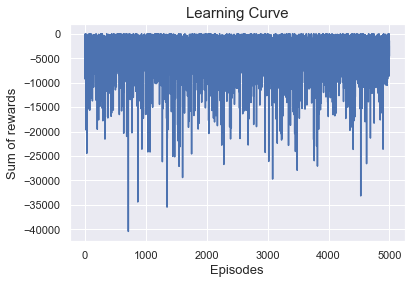

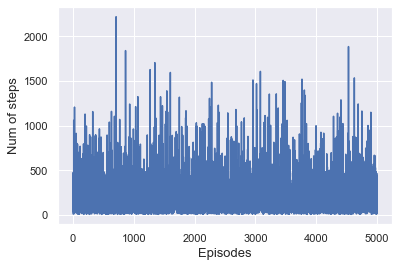

In [4]:
env = SnakeAndApple()
learning = QL()
# aplha: learning_rate
# gamma: discount factor
learning.learnStochastic(env, max_itr=5000, alpha=0.1, gamma=0.6)

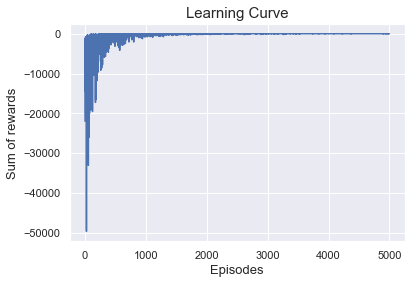

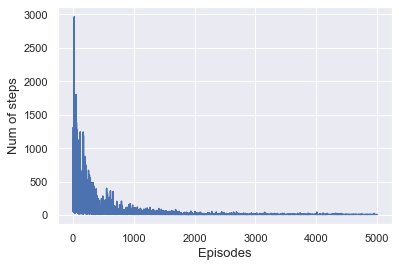

got apple!
total reward: 1


In [5]:
learning.learnQ(env, max_itr=5000, alpha=0.1, gamma=0.6)
env.play_with_q(max_itr=1000, q_table=learning.q_table)

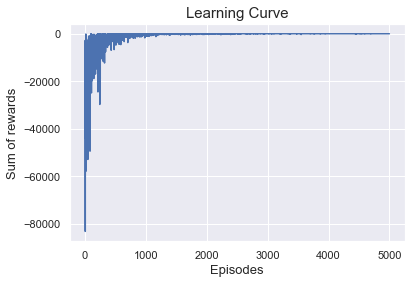

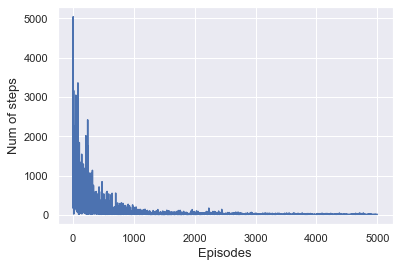

got apple!
total reward: -4


In [6]:
learning.learnSarsa(env, max_itr=5000, alpha=0.1, gamma=0.6)
env.play_with_q(max_itr=1000, q_table=learning.q_table)

In [7]:
from keras import Sequential
from collections import deque
from keras.layers import *
from tensorflow.keras.optimizers import Adam

class DQN:
    
    def __init__(self, env, batch_size):
        self.action_space = len(env.actions())
        self.state_space = env.state_space
        self.epsilon = 1
        self.gamma = 0.3
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.learning_rate = 0.00025
        self.batch_size = batch_size
        self.layer_sizes = [128, 128, 128]
        self.memory = deque(maxlen=100000)
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        for i in range(len(self.layer_sizes)):
            if i == 0:
                model.add(Dense(self.layer_sizes[i], input_shape=(self.state_space,), activation='relu'))
            else:
                model.add(Dense(self.layer_sizes[i], activation='relu'))
        model.add(Dense(self.action_space, activation='softmax'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        # dropout_prob = 0.1
        # model.add(BatchNormalization(axis=1, input_shape=self.state_space))
        # model.add(Convolution2D(32, 2, 2, border_mode='valid',
        #                              subsample=(2, 2), dim_ordering='th'))
        # model.add(Activation('relu'))

        # model.add(BatchNormalization(axis=1))
        # model.add(Convolution2D(64, 2, 2, border_mode='valid',
        #                              subsample=(2, 2), dim_ordering='th'))
        # model.add(Activation('relu'))

        # model.add(BatchNormalization(axis=1))
        # model.add(Convolution2D(64, 3, 3, border_mode='valid',
        #                              subsample=(2, 2), dim_ordering='th'))
        # model.add(Activation('relu'))

        # model.add(Flatten())

        # model.add(Dropout(dropout_prob))
        # model.add(Dense(512))
        # model.add(Activation('relu'))

        # model.add(Dense(self.action_space))

        # model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_dqn(max_itr, batch_size, env):
    sum_of_rewards = []
    agent = DQN(env, batch_size)
    env.start()
    env.plot = True
    for epoch in range(max_itr):
        env.reset()
        state = np.reshape(env.get_state(), (1, env.state_space))
        rewards = 0
        for i in range(10000):
            action = agent.act(state)
            prev_state = state
            reward = env.step2(env.actions()[action])
            rewards += reward
            next_state = np.reshape(env.get_state(), (1, env.state_space))
            agent.remember(state, action, reward, next_state, env.crashed)
            state = next_state
            if batch_size > 1:
                agent.replay()
            if env.crashed:
                print(f'\rEpisode:{epoch+1}', end="...\t\t")
                break
        sum_of_rewards.append(rewards)
    env.window.destroy()
    return sum_of_rewards
    

In [8]:
snake_initial_length = 1
env = SnakeAndApple()
sum_of_rewards = train_dqn(max_itr=200, batch_size=500, env=env)

Episode:105...		

In [ ]:
plt.plot(sum_of_rewards)
plt.title('Learning Curve', fontsize = 15)
plt.xlabel('Episodes', fontsize = 13)
plt.ylabel('Sum of rewards', fontsize = 13)
plt.show()